Estudiantes:

Nicolas Grezzi 189702

Mariano Chicatun 301379

# Monte Carlo Methods

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en OpenAi gym (https://gym.openai.com/), es el caso esta vez de otro ambiente sencillo: el juego de Blackjack. El ambiente esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por lo que no es necesario crearlo desde cero. 

***
### Juego de Blackjack

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable".
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador de queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

Ambiente:
- La reward por perder es -1, por ganar es +1 y por pedir carta es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

***

### A entregar:

- Notebook con solución a los algoritmos presentados
- Analisis de la funcion de valor estimada para distinto número de episodios a visitar (ej: 100, 1000, 10000, 50000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de funcion de valor para otras dos politicas definidas por el estudiante. 

In [2]:
# Para utilizar la nueva version de GYM, si es necesario reiniciar ambiente
#!pip install --upgrade gym
#!conda install --upgrade gym
#!conda install tqdm

     -------------------------------------- 721.7/721.7 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827640 sha256=dc2e83f2d9a880f1735961a4d63d4b165c8cee06041be1d9c83832b5dd38c7c9
  Stored in directory: c:\users\scruple077\appdata\local\pip\cache\wheels\af\2b\30\5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym


In [106]:
# Imports necesarios
import gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Creacion del ambiente
#env = gym.make('Blackjack-v0')
env = gym.make('Blackjack-v1',natural=False, sab=True)

# Acciones: 0 = Stick, 1 = HIT
print(env.observation_space)

#obs = env.reset()
obs, _ = env.reset()
print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")


#nueva_obs, reward, done, _ = env.step(0)
nueva_obs, reward, done, truncated, _ = env.step(0)

print(f"Nuevo estado: {nueva_obs}, Recompensa: {reward}, Estado Final: {done}")

Tuple(Discrete(32), Discrete(11), Discrete(2))
Jugador: 8, Dealer: 10, As usable: False 
Nuevo estado: (8, 10, False), Recompensa: -1.0, Estado Final: True


In [181]:
# Caso de prueba
#state,_ = env.reset()
state,_ = env.reset()
print('state:', state)

while True:
    action = env.action_space.sample()
    #state, reward, done, _ = env.step(action)
    state, reward, done, truncated, _ = env.step(action)
    print('state:', state, 'reward:', reward, 'done:', done, 'truncated:', truncated)
    if done or truncated:
        print(f'Reward:{reward}')                
        break

state: (11, 1, False)
state: (11, 1, False) reward: -1.0 done: True truncated: False
Reward:-1.0


## El algoritmo que vamos a implementar

Vamos a comenzar con el algoritmo 5.1 del libro: `First Visit MC prediction` para estimar la función de valor de una política arbitraria. 

![Image](https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/assets/0501_FV_MC_Pred.png)

En este caso vamos a querer evaluar una politica que se queda si el jugador tiene un valor mayor o igual a 19, y pide cartas en caso contrario. 



In [297]:
STICK = 0
HIT = 1
       
## Politica
def sample_policy(observation):
    player_sum, dealer_card, usable_ace = observation
    #print(player_sum)
    return STICK if player_sum >= 19 else HIT

def sample_policy_20(observation):
    player_sum, dealer_card, usable_ace = observation
    #print(player_sum)
    return STICK if player_sum >= 20 else HIT

def policy_2(observation):
    player_sum, dealer_card, usable_ace = observation
    #print(player_sum)
    return STICK if player_sum >= 17 or (player_sum<=11 and player_sum>=9) else HIT

In [305]:
state,_ = env.reset()
print(state)
print(sample_policy(state))
print(sample_policy_20(state))
print(policy_2(state))

#env.reset()[0]

(10, 7, False)
1
1
0


In [274]:
env.reset()[0]
env.step(action)

((20, 6, False), 1.0, True, False, {})

In [118]:
## Generar Episodio
def generate_episode(policy, env):
    state = env.reset()[0]
    states, actions, rewards = [], [], []
    while True:
        action = policy(state)
        next_state, reward, done, truncated,_ = env.step(action)
        states.append(next_state)
        actions.append(action)
        rewards.append(reward)
        state = next_state
        if done:
            break
    #TODO: Implement
    return states, actions, rewards

In [229]:
## Generar Episodio
def generate_episode(policy, env):
    state = env.reset()[0]
    states, actions, rewards = [], [], []
    episode = []

    while True:
        action = policy(state)
        next_state, reward, done, truncated,_ = env.step(action)
        states.append(next_state)
        actions.append(action)
        rewards.append(reward)
        episode.append((state, action, reward))

        state = next_state
        if done:
            break
    #TODO: Implement
    return episode

In [224]:
states, actions, rewards = generate_episode(sample_policy, env)
print(states)
print(actions)
print(rewards)
episode = zip(states, actions, rewards)


[(22, 7, False)]
[1]
[-1.0]


In [149]:
## Algoritmo
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    V = defaultdict(float)
    for n_episodes in range(number_episodes):
        states,actions,rewards = generate_episode(policy, env)
        visited_states = set(states)
        for state in visited_states:
            first_visit = states.index(state)
            G = sum([x*(gamma**i) for i,x in enumerate(rewards[first_visit:])])
            returns_sum[state] += G
            returns_count[state] += 1
            V[state] = returns_sum[state]/returns_count[state]
    return V




In [253]:
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    V = defaultdict(float)
    for n_episodes in range(number_episodes):
        episode = generate_episode(policy, env)
        visited_states = set([x[0] for x in episode])
        for state in visited_states:
            first_visit = next(i for i, x in enumerate(episode) if x[0] == state)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_visit:])])
            returns_sum[state] += G
            returns_count[state] += 1
            V[state] = returns_sum[state]/returns_count[state]
    return V

In [310]:
# Uso copy popitem modifica la estructura
from copy import copy
number_episodes = 1000000
value = first_visit_mc_prediction(sample_policy, env, number_episodes = number_episodes)
value_20 = first_visit_mc_prediction(sample_policy_20, env, number_episodes = number_episodes)
value_2 = first_visit_mc_prediction(policy_2, env, number_episodes = number_episodes)

# valueaux = copy(value)
# for i in range(10):
    #print(valueaux.popitem())

Politica >= 19


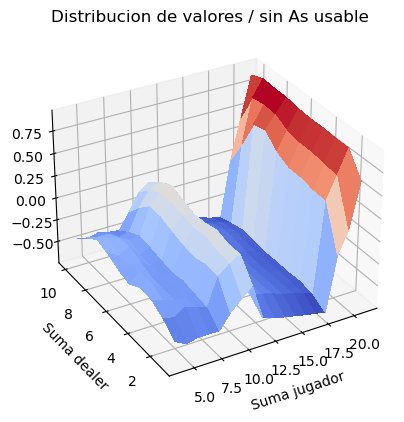

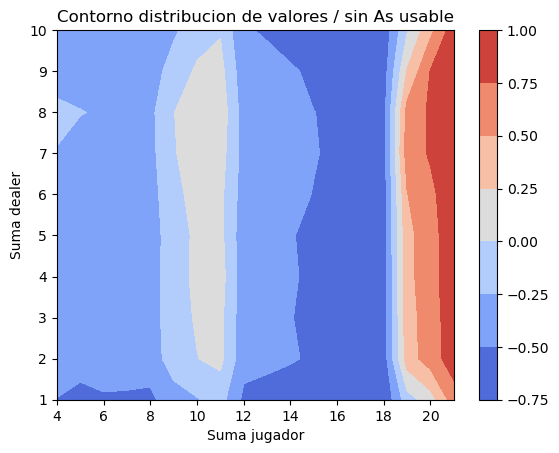

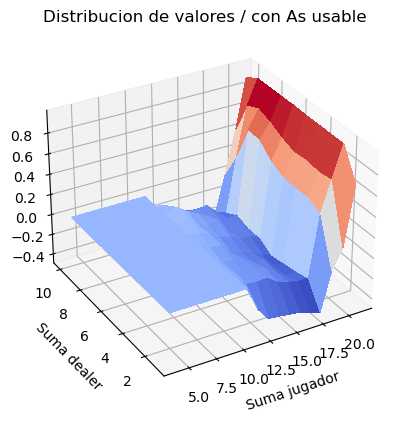

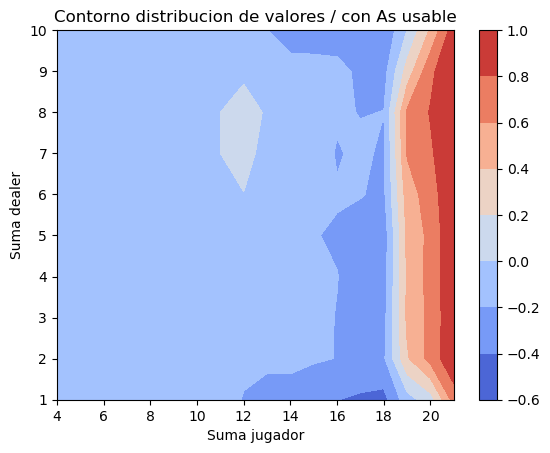

Politica >= 20


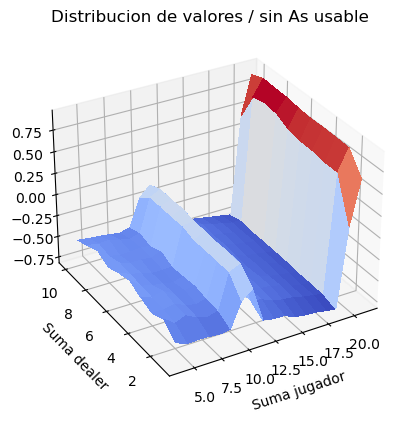

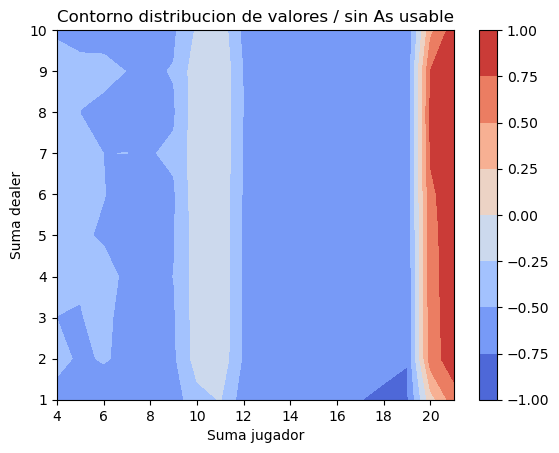

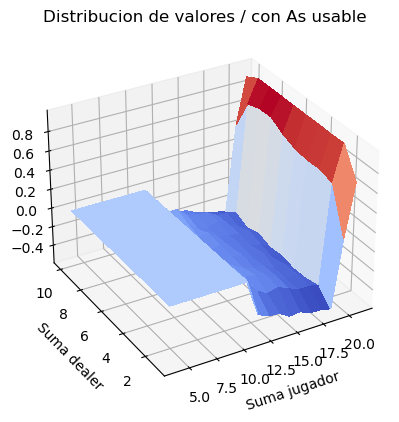

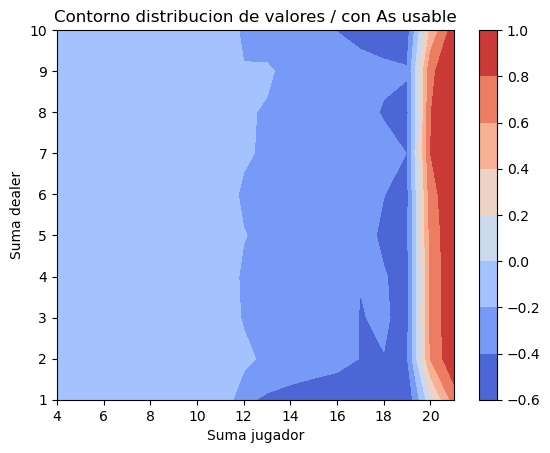

9<=Politica<=11 or Politica >= 17 


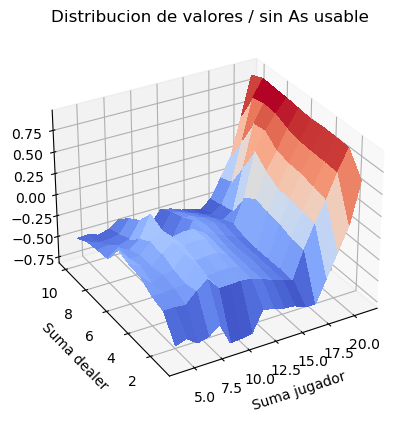

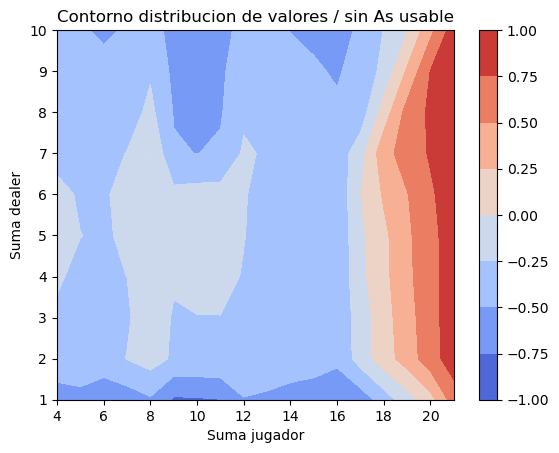

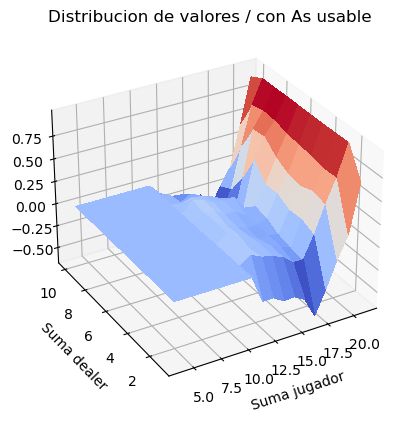

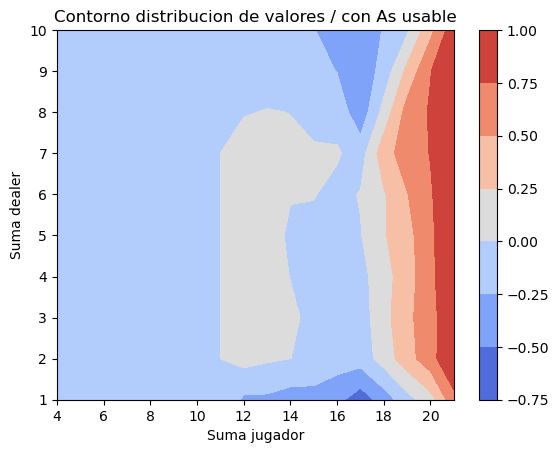

In [311]:
print('Politica >= 19')
plot_value_distribution(value)
print('Politica >= 20')
plot_value_distribution(value_20)
print('9<=Politica<=11 or Politica >= 17 ')
plot_value_distribution(value_2)


Algunas conclusiones:
- La mejor política parece ser la de Stick cuando la suma de las cartas es >=19 dado que hay una mayor área en color más rojizo. 
- Cuando el As es usable es más probable empatar, ya que disminuyen la probabilidad de perder. La recompensa es más cercana a 0 -> Empate. 
- La peor política es la de 20 porque es más restrictiva y es la que tiene menos recompensas. 
- Se podría diseñar una política que contemple también la suma dealer. 

In [162]:
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_value_distribution(value):
    min_x = min(k[0] for k in value.keys())
    max_x = max(k[0] for k in value.keys())
    min_y = min(k[1] for k in value.keys())
    max_y = max(k[1] for k in value.keys())

    player_sum = np.arange(min_x, max_x + 1)
    dealer_show = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(player_sum, dealer_show)

    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = value[player, dealer, ace]
    
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection='3d')
    plt.title("Distribucion de valores / sin As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.view_init(ax.elev, -120)
    ax.plot_surface(X, Y, state_values[:, :, 0].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()

    #Gráfico de contorno
    cp = plt.contourf(X, Y, state_values[:, :, 0].T, cmap=cm.coolwarm)
    plt.title("Contorno distribucion de valores / sin As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")        
    plt.colorbar(cp)
    plt.show()

    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection='3d')
    plt.title("Distribucion de valores / con As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")
    ax.view_init(ax.elev, -120)
    ax.plot_surface(X, Y, state_values[:, :, 1].T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()
    
    #Gráfico de contorno
    cp = plt.contourf(X, Y, state_values[:, :, 1].T, cmap=cm.coolwarm)
    plt.title("Contorno distribucion de valores / con As usable")
    plt.xlabel("Suma jugador")
    plt.ylabel("Suma dealer")        
    plt.colorbar(cp)
    plt.show()
    

Number of episodes:  100
Politica >= 19


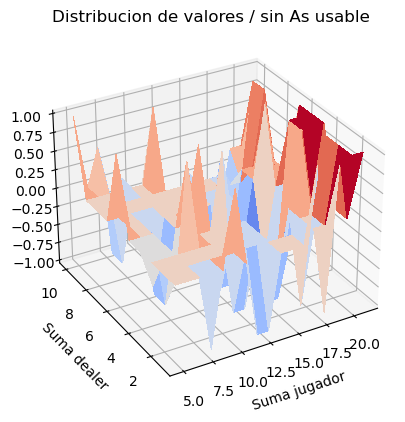

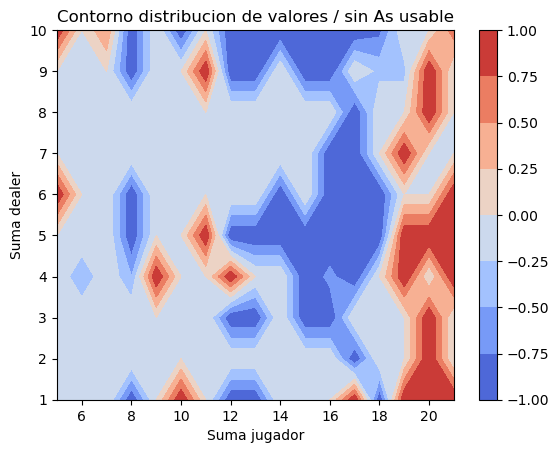

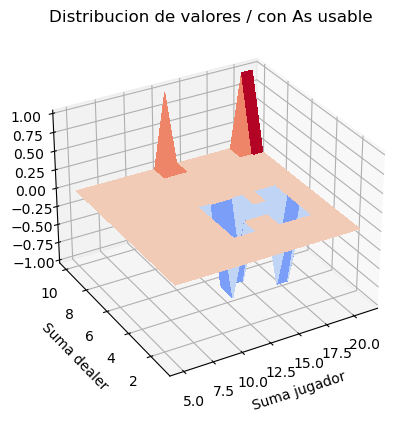

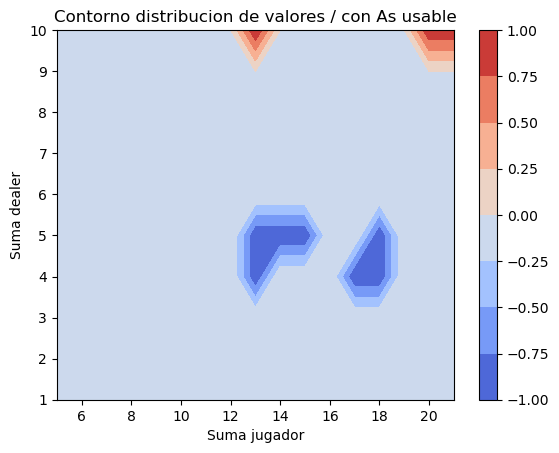

Politica >= 20


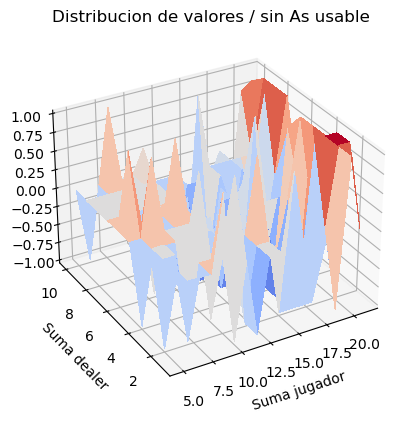

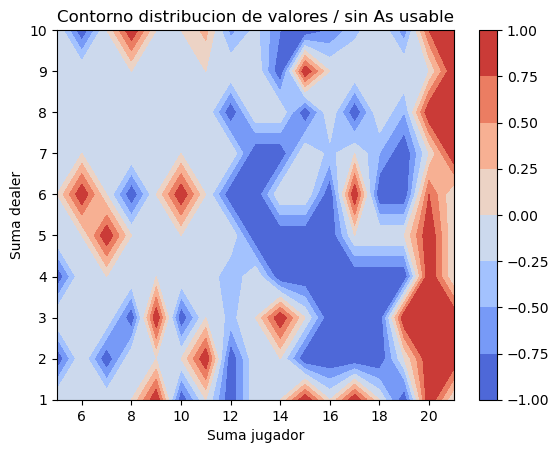

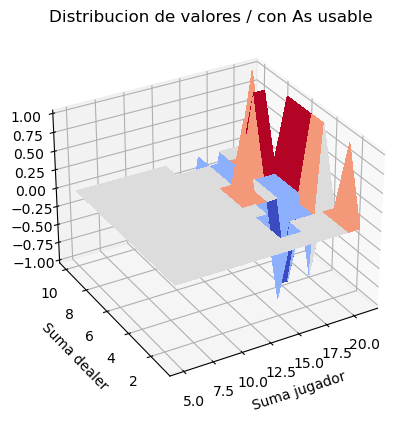

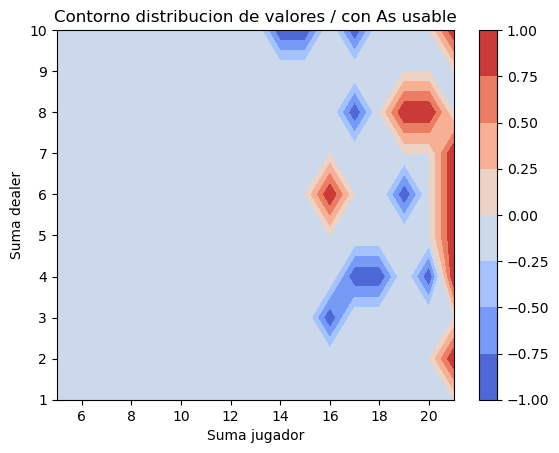

9<=Politica<=11 or Politica >= 17 


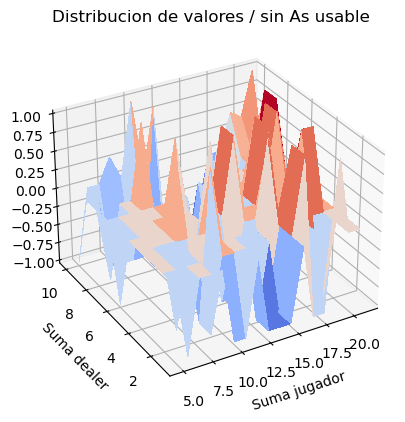

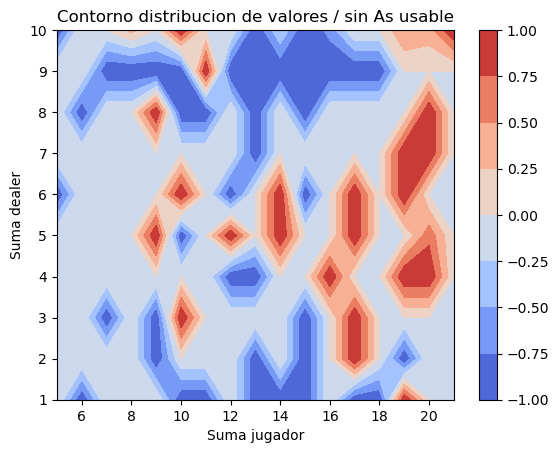

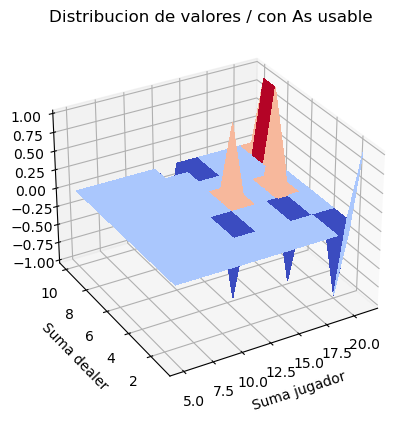

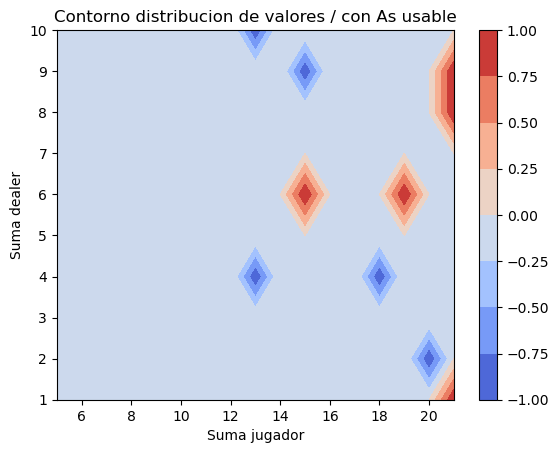

Number of episodes:  1000
Politica >= 19


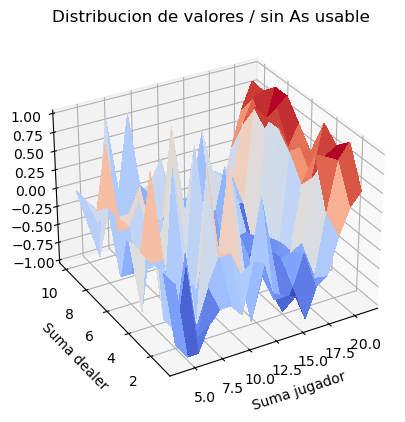

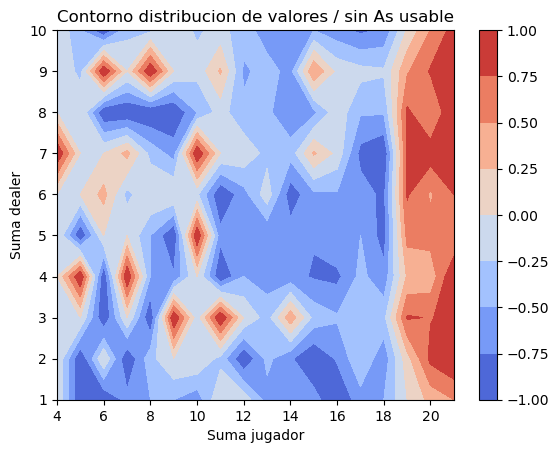

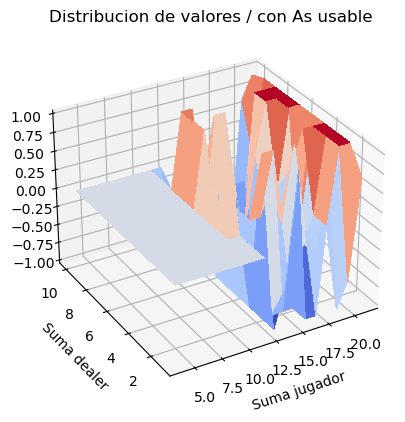

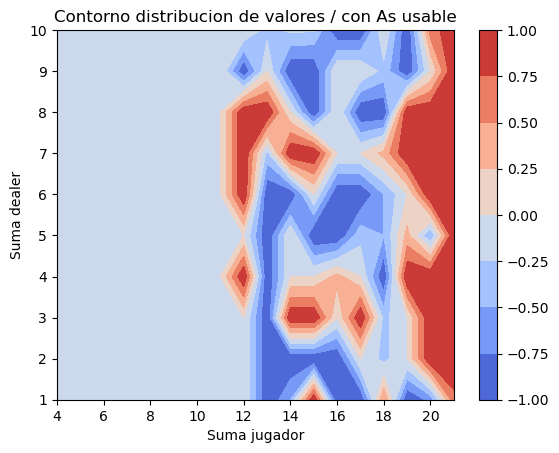

Politica >= 20


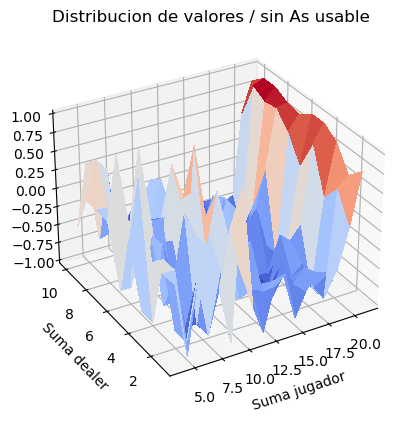

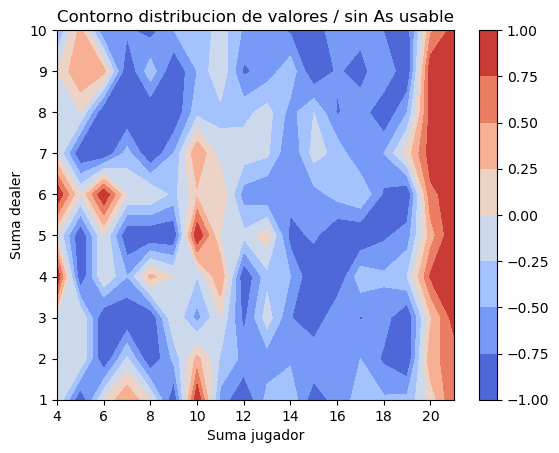

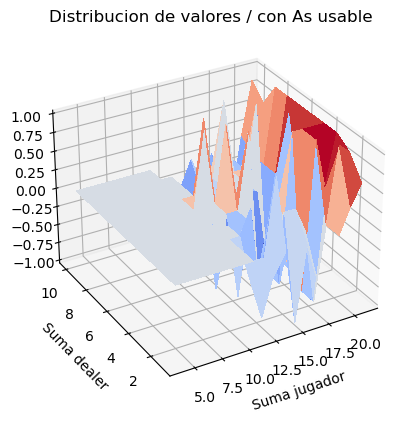

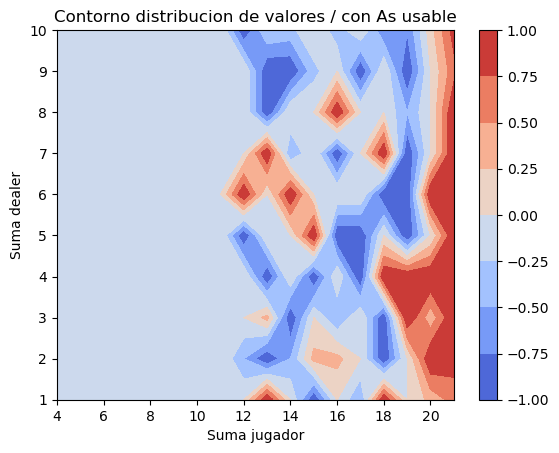

9<=Politica<=11 or Politica >= 17 


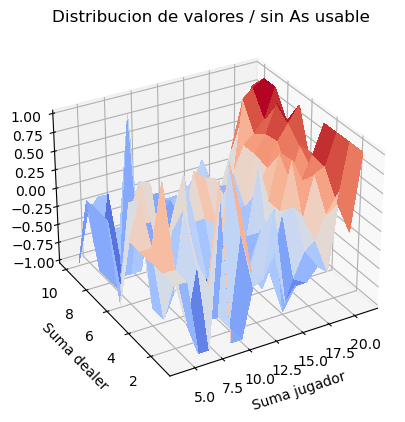

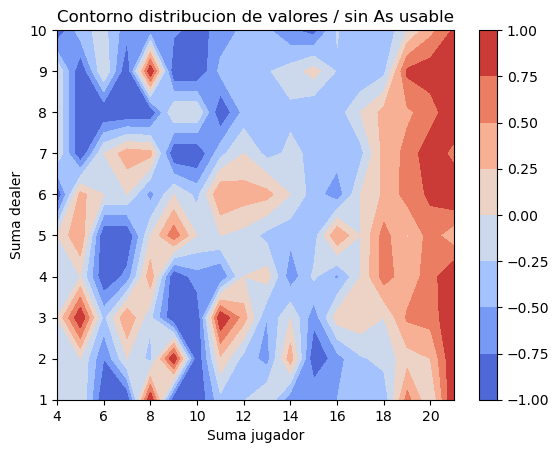

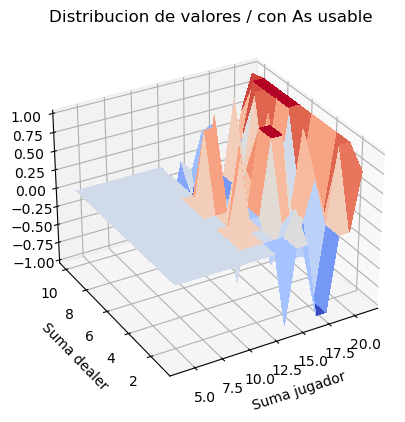

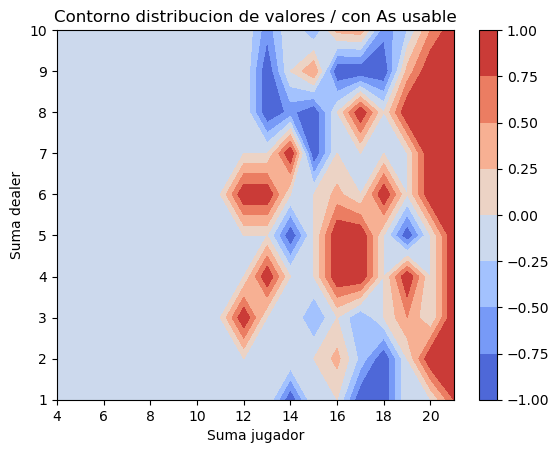

Number of episodes:  10000
Politica >= 19


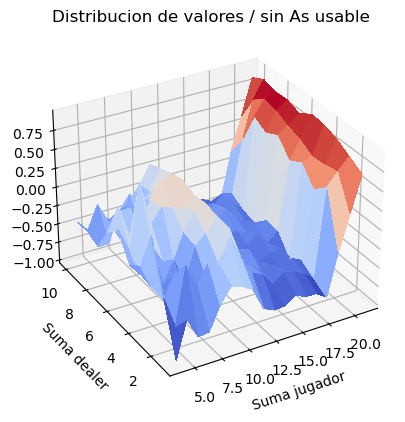

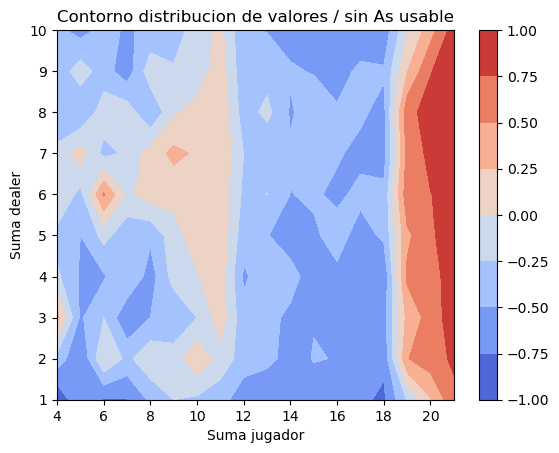

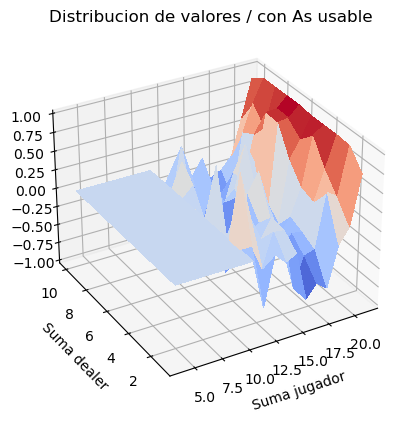

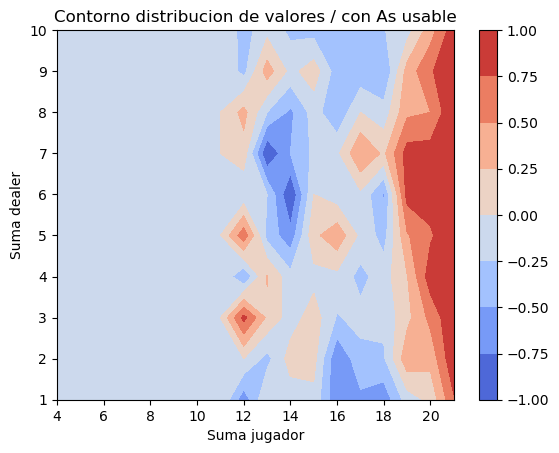

Politica >= 20


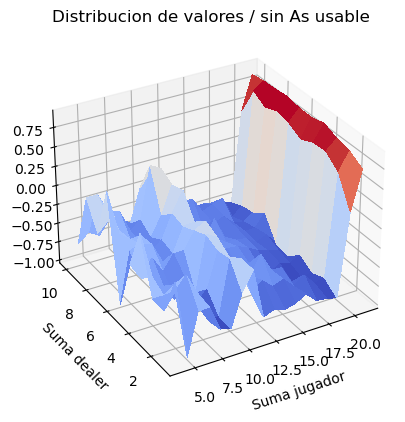

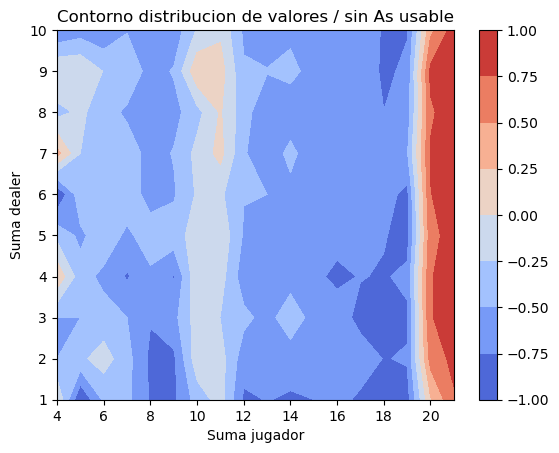

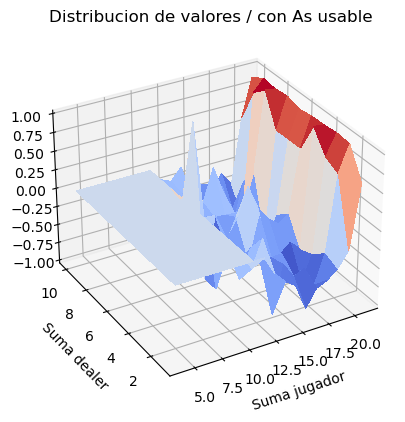

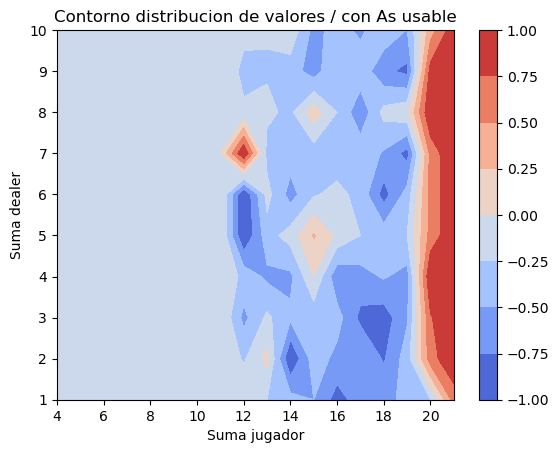

9<=Politica<=11 or Politica >= 17 


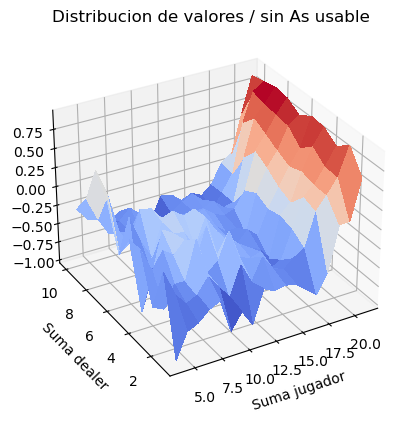

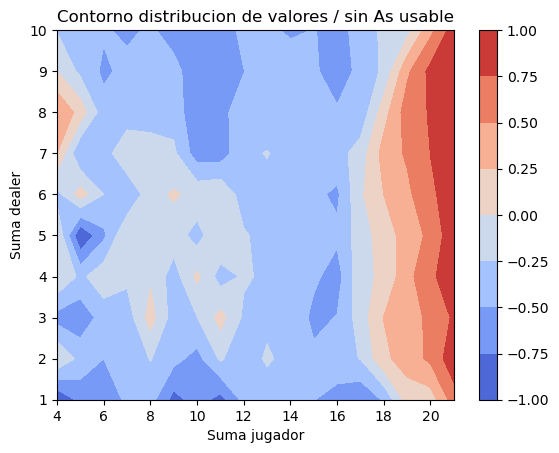

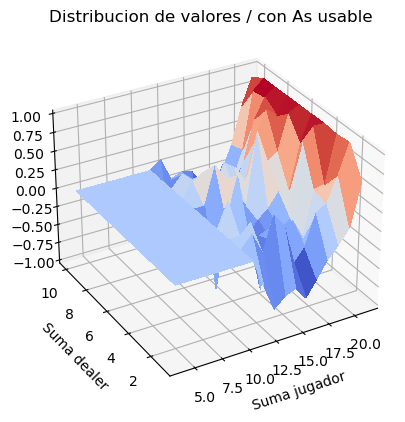

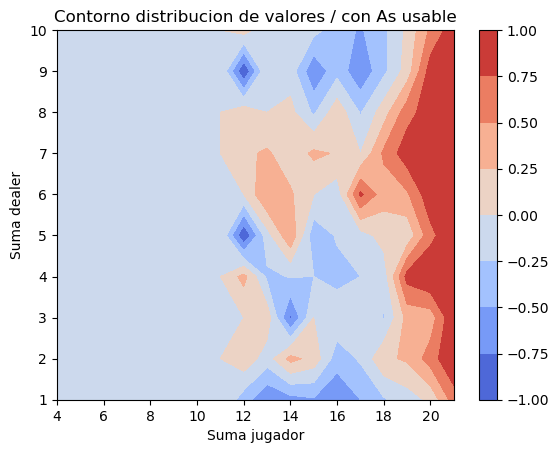

Number of episodes:  100000
Politica >= 19


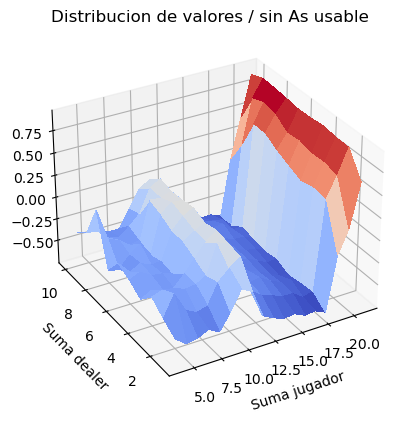

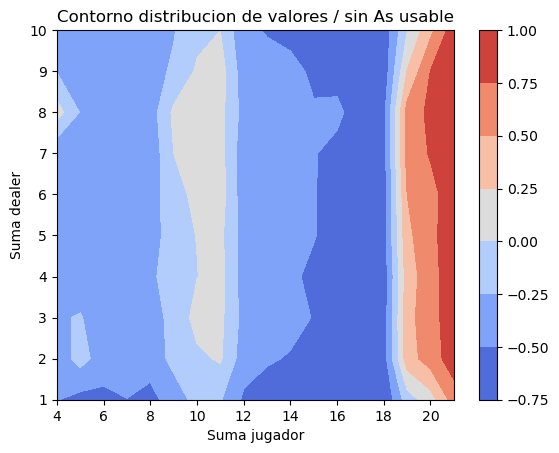

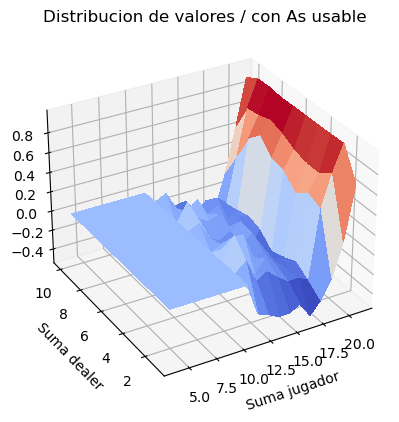

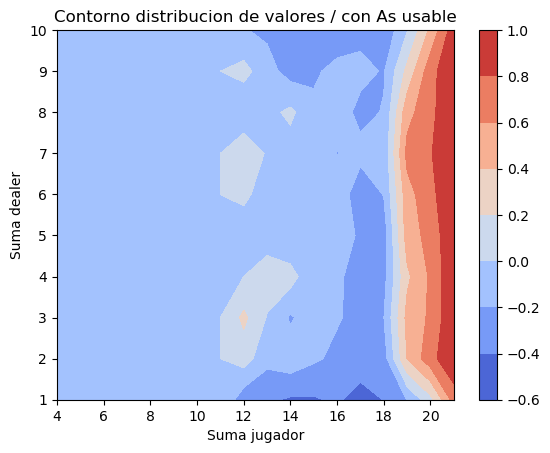

Politica >= 20


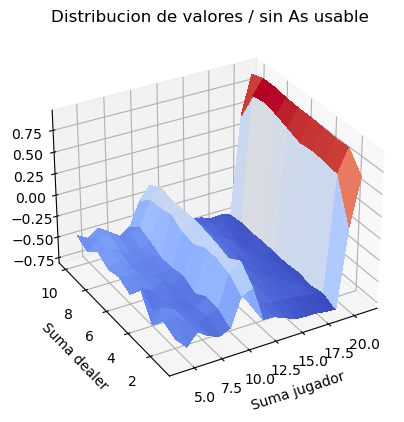

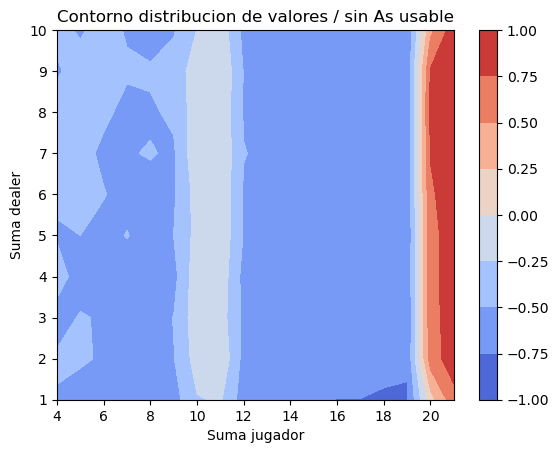

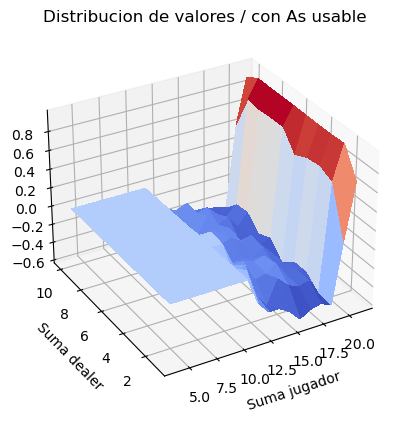

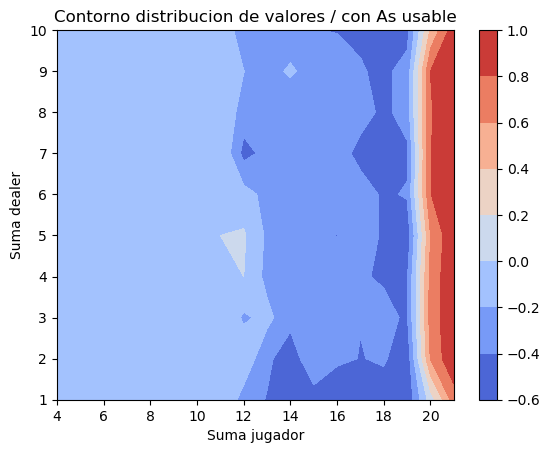

9<=Politica<=11 or Politica >= 17 


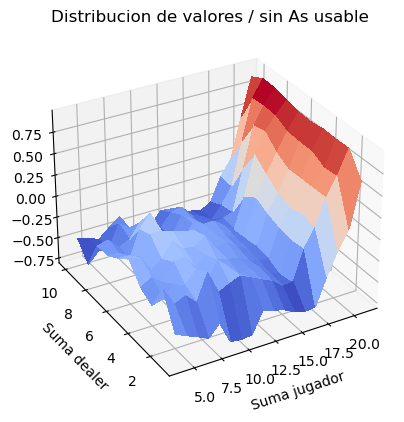

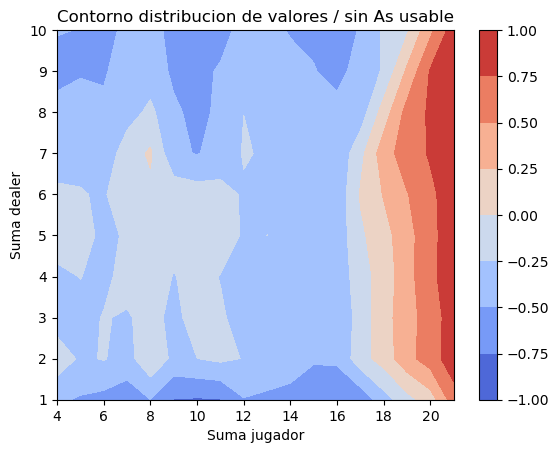

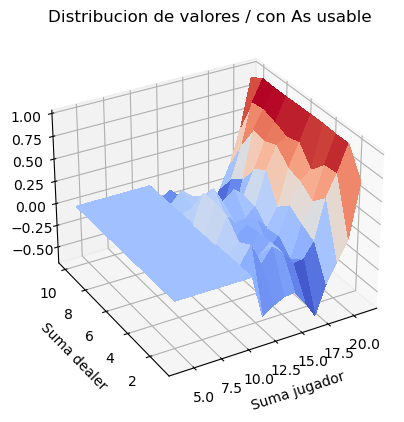

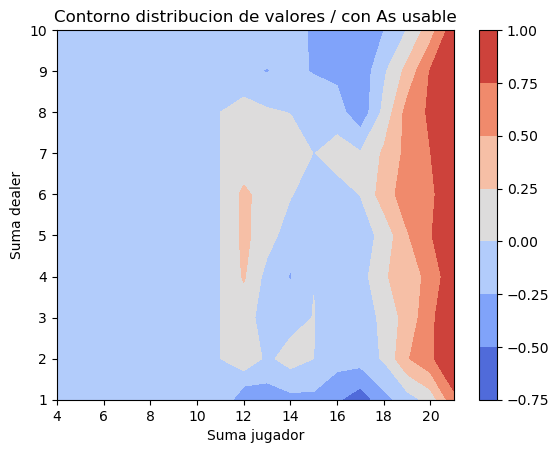

In [309]:
for number_episodes in [100,1000,10000, 100000]:
    value = first_visit_mc_prediction(sample_policy, env, number_episodes = number_episodes)
    value_20 = first_visit_mc_prediction(sample_policy_20, env, number_episodes = number_episodes)
    value_2 = first_visit_mc_prediction(policy_2, env, number_episodes = number_episodes)

    print('Number of episodes: ', number_episodes)

    print('Politica >= 19')

    plot_value_distribution(value)

    print('Politica >= 20')
    plot_value_distribution(value_20)
    print('9<=Politica<=11 or Politica >= 17 ')
    plot_value_distribution(value_2)

La estimación de la función de valor es muy dependiente del número de episodios, dado que la estimación se realiza aprendiendo de la experiencia a lo largo de los episodios. Al aumentar el número de episodios obtenemos de forma iterativa un mejor estimador de la función de valor, por la ley de los grandes números el método de Monte Carlo converge a una estimación de la función de valor.  

In [ ]:
# Train the model
n_episodes = 500000
V = first_visit_mc_prediction(sample_policy_20, env, n_episodes)

In [316]:
# Test the learned policy
n_test_episodes = 100000
win_count = 0
draw_count = 0


def test_policy(policy, env,m_test_episodes = 100000):
    win_count = 0
    draw_count = 0
    for _ in range(m_test_episodes):
        episode = generate_episode(policy, env)
        _, _, reward = episode[-1]
        if reward == 1:
            win_count += 1
        elif reward == 0:
            draw_count += 1
    win_rate = win_count / m_test_episodes
    draw_rate = draw_count / m_test_episodes
    return win_rate, draw_rate

win_rate, draw_rate = test_policy(sample_policy, env)
print("Sum_Cards >=19, Win: ",win_rate," Draw: ",draw_rate)
win_rate, draw_rate = test_policy(sample_policy_20, env)
print("Sum_Cards >=20, Win: ",win_rate," Draw: ",draw_rate)
win_rate, draw_rate = test_policy(policy_2, env)
print("9<=Sum_Cards<=11 or Sum_Cards >=17, Win: ",win_rate," Draw: ",draw_rate)





Sum_Cards >=19, Win:  0.36533  Draw:  0.07227
Sum_Cards >=20, Win:  0.29893  Draw:  0.05593
9<=Sum_Cards<=11 or Sum_Cards >=17, Win:  0.38323  Draw:  0.08532


La mejor política según el win_rate es la de 9<=Sum_Cards<=11 or Sum_Cards>=17 

## Opcional
En esta sección presentamos las definiciones de funciones del resto de las técnicas vistas en teórico para aquellos que quieran implementarlas.

In [237]:
def first_visit_mc_prediction_Q(policy, env, number_episodes, gamma=1):
    #TODO: Implement
    """
    Los siguientes snippets pueden serle de utilidad:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
        states_actions = list(zip(states, actions))
    """
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for episode_num in range(number_episodes):
        episode = generate_episode(policy, env)
        #episode = (states,actions,rewards)
        #visited_state_actions = set(zip(states, actions))
        visited_state_actions = set([(x[0], x[1]) for x in episode])
        for state, action in visited_state_actions:
            #first_visit = states.index(state)
            first_occurrence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)

            #G = sum([x*(gamma**i) for i,x in enumerate(rewards[first_visit:])])
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurrence_idx:])])

            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1
            Q[state][action] = returns_sum[(state, action)]/returns_count[(state, action)]
    
    return Q

¿Observa algo extraño en los valores Q?

La mayoría son negativos, dado por la naturaleza del blackjack. "La casa siempre gana". 

In [317]:
Qvalues = first_visit_mc_prediction_Q(sample_policy, env, number_episodes=500000)
Qvaluesaux = copy(Qvalues)
for i in range(10):
    print(Qvaluesaux.popitem())


((14, 3, True), array([ 0.       , -0.1539924]))
((14, 5, True), array([ 0.        , -0.17748092]))
((6, 4, False), array([ 0.        , -0.32697947]))
((12, 8, True), array([ 0.        , -0.03252033]))
((12, 6, True), array([0.        , 0.02183406]))
((13, 2, True), array([ 0.        , -0.20469083]))
((5, 1, False), array([ 0. , -0.5]))
((12, 7, True), array([ 0.        , -0.01388889]))
((5, 6, False), array([ 0.        , -0.33628319]))
((5, 7, False), array([ 0.       , -0.3916849]))


In [262]:
# Train the model
Q = Qvalues

# Test the learned policy
n_test_episodes = 100000
win_count = 0
draw_count = 0

for _ in range(n_test_episodes):
    episode = generate_episode(sample_policy, env)
    _, _, reward = episode[-1]

    if reward == 1:
        win_count += 1
    elif reward == 0:
        draw_count += 1

win_rate = win_count / n_test_episodes
draw_rate = draw_count / n_test_episodes
print("Win rate: ", win_rate)
print("Draw rate: ", draw_rate)

Win rate:  0.36704
Draw rate:  0.07087


In [14]:
def epsilon_greedy_policy(Q, state, epsilon, nA):
    if np.random.random() < epsilon:
        return np.random.randint(nA)
    else:
        return np.argmax(Q[state])
    
def generate_episode(Q, epsilon, env):
    observation = env.reset()
    episode = []
    nA = env.action_space.n

    while True:
        action = epsilon_greedy_policy(Q, observation, epsilon, nA)
        next_observation, reward, done, _ = env.step(action)
        episode.append((observation, action, reward))
        observation = next_observation

        if done:
            break

    return episode

def first_visit_mc_prediction_Q_with_initial_exploration(policy, env, number_episodes, gamma=1):
    #TODO: Implement
    """
    Los siguientes snippets pueden serle de utilidad:
        random_action = env.action_space.sample()
        random_state = env.observation_space.sample()
    """
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for episode_num in range(n_episodes):
        episode = generate_episode(Q, epsilon, env)
        visited_state_actions = set([(x[0], x[1]) for x in episode])

        for state, action in visited_state_actions:
            first_occurrence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (gamma**i) for i, x in enumerate(episode[first_occurrence_idx:])])
            sa_pair = (state, action)
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    return Q


Antes de implementar Control MC, definiremos la clase Policy.

Esta se puede instanciar tanto para implementar:
- Una política puramente greedy (ε = 0) para Control MC **con** exploración inicial
- Una política ε-greedy para Control MC **sin** exploración inicial

In [15]:
class Policy:
    """
    Implements an epsilon-soft policy, one that returs a probability distribution for each possible action.
    
    Params
    ------
        Q: dictionary of state-action keys -> array of returns.
        number_actions: number of possible actions in the env.
        epsilon: exploration parameter where 1 explores all the time and 0 is greedy. 
    """
    
    def __init__(self, Q, number_actions, epsilon=0.1):
        self.Q = Q
        self.number_actions = number_actions
        self.epsilon = epsilon
    
    def __call__(self, observation):
        #TODO: implement
        # Se debe retornar el vector de probabilidades (página 14 del teórico).
        # Recordar, si ε = 0 -> la política es la greedy (página 13 del teórico).
        pass
    
    def update(self, new_Q):
        self.Q = new_Q

In [ ]:
def monte_carlo_control_without_initial_exploration(env, num_episodes, gamma=1, epsilon=0.1):
    #TODO: Implement
    pass